In [1]:
from astropy.table import Table, join
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
import arviz as az
import kinesis as kn
import gapipes as gp

In [2]:
from astropy.io import ascii
vas = ascii.read('/Users/apricewhelan/data/Misc/Vasiliev-globclust.txt', format='basic')
ocen_dist = vas[vas['Name'] == 'NGC 5139 (omega Cen)']['D']

In [3]:
cen_c = coord.SkyCoord(201.697, -47.47947222, unit=u.deg)

In [4]:
allstar = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')
big_sky_mask = coord.SkyCoord(allstar['RA'], allstar['DEC'], unit=u.deg).separation(cen_c) < 5*u.deg
allstar = Table(allstar[big_sky_mask])

xm_gaia = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStar-r12-gaiadr2.fits')
big_sky_mask = coord.SkyCoord(xm_gaia['RA'], xm_gaia['DEC'], unit=u.deg).separation(cen_c) < 5*u.deg
xm_gaia = Table(xm_gaia[big_sky_mask])
xm_gaia.rename_column('apogee_id', 'APOGEE_ID')

In [5]:
tbl = join(allstar, xm_gaia, keys='APOGEE_ID')
_, idx = np.unique(tbl['APOGEE_ID'], return_index=True)
tbl = tbl[idx]

keep_colnames = []
for colname in tbl.colnames:
    if len(tbl[colname].shape) == 1:
        keep_colnames.append(colname)
tbl = tbl[keep_colnames]

g = GaiaData(tbl)
len(g)

1585

In [6]:
c = g.get_skycoord(distance=False, radial_velocity=g.VHELIO_AVG*u.km/u.s)

1156

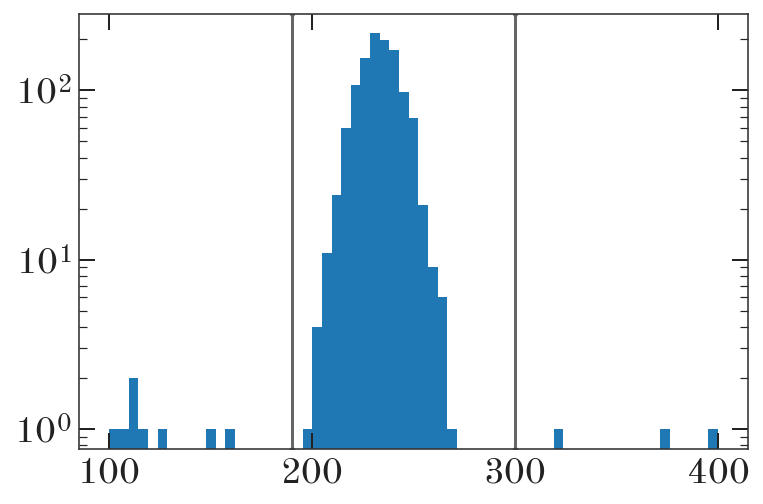

In [7]:
plt.hist(c.radial_velocity.value, bins=np.linspace(100, 400, 64));
om_cen_rv_mask = (c.radial_velocity.value > 190.) & (c.radial_velocity.value < 300.)
plt.yscale('log')
plt.axvline(190)
plt.axvline(300)
om_cen_rv_mask.sum()

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(-10, 0)

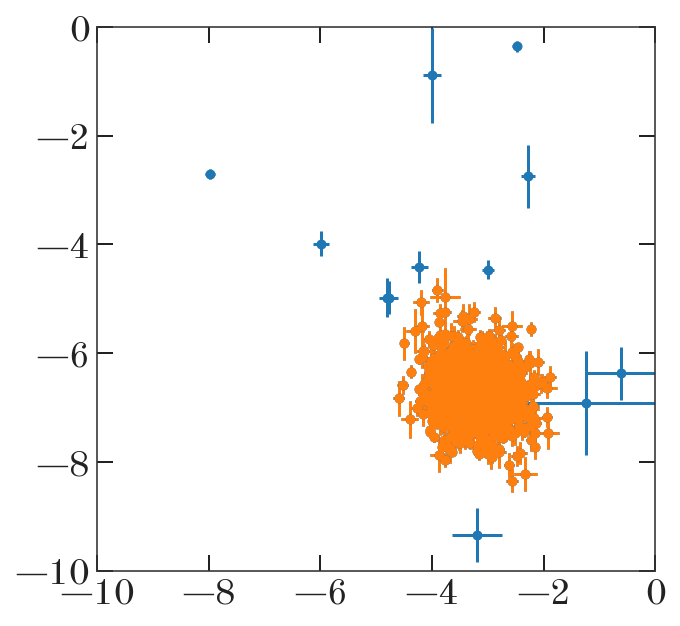

In [8]:
plt.figure(figsize=(5, 5))
plt.errorbar(tbl['pmra'][om_cen_rv_mask],
             tbl['pmdec'][om_cen_rv_mask],
             xerr=tbl['pmra_error'][om_cen_rv_mask],
             yerr=tbl['pmdec_error'][om_cen_rv_mask], 
             marker='o', ls='none')

om_cen_pm_mask = np.sqrt((tbl['pmra'] - np.nanmedian(tbl['pmra']))**2 + 
                         (tbl['pmdec'] - np.nanmedian(tbl['pmdec']))**2) < 2.
plt.errorbar(tbl['pmra'][om_cen_rv_mask & om_cen_pm_mask],
             tbl['pmdec'][om_cen_rv_mask & om_cen_pm_mask],
             xerr=tbl['pmra_error'][om_cen_rv_mask & om_cen_pm_mask],
             yerr=tbl['pmdec_error'][om_cen_rv_mask & om_cen_pm_mask], 
             marker='o', ls='none')

plt.xlim(-10, 0)
plt.ylim(-10, 0)

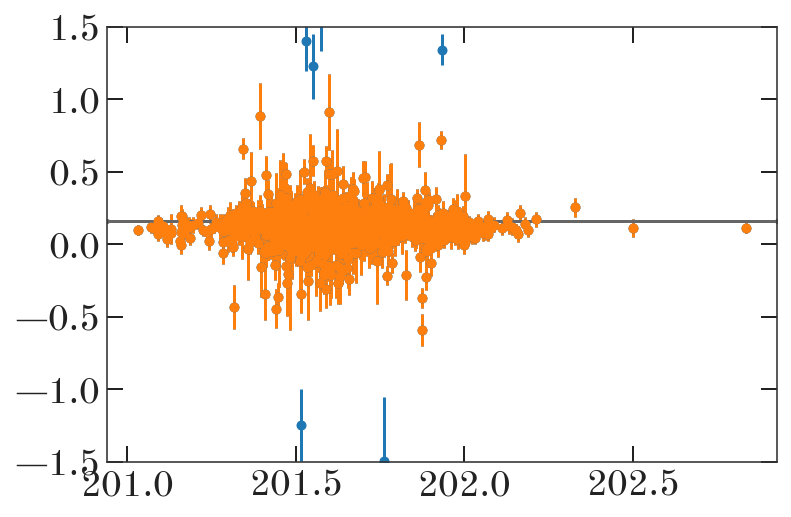

In [9]:
plt.errorbar(tbl['ra'][om_cen_rv_mask & om_cen_pm_mask], 
             tbl['parallax'][om_cen_rv_mask & om_cen_pm_mask],
             yerr=tbl['parallax_error'][om_cen_rv_mask & om_cen_pm_mask],
             marker='o', ls='none')

om_cen_plx_mask = np.abs(tbl['parallax'] - 0.2) < 1.
plt.errorbar(tbl['ra'][om_cen_rv_mask & om_cen_pm_mask & om_cen_plx_mask], 
             tbl['parallax'][om_cen_rv_mask & om_cen_pm_mask & om_cen_plx_mask],
             yerr=tbl['parallax_error'][om_cen_rv_mask & om_cen_pm_mask & om_cen_plx_mask],
             marker='o', ls='none')
plt.ylim(-1.5, 1.5)
plt.axhline(1/5.2 - 0.03)

In [10]:
om_cen_mask = om_cen_rv_mask & om_cen_pm_mask & om_cen_plx_mask
ocen = tbl[om_cen_mask]
om_cen_mask.sum()

1080

In [11]:
fitter = kn.Fitter(include_T=True)

INFO:kinesis.models:Reading model from disk


In [12]:
def get_df(tbl):
    tbl['radial_velocity'] = tbl['VHELIO_AVG']
    tbl['radial_velocity_error'] = tbl['VERR']

    # Set parallaxes to distance we get from isochrone fitting with big uncertainty
    plx = coord.Distance(np.random.normal(28.7, 0.5, size=1000)*u.kpc).parallax
    tbl['parallax'] = 1 / ocen_dist[0]
    tbl['parallax_error'] = 0.01
    for colname in tbl.colnames:
        if 'parallax' in colname and 'corr' in colname:
            tbl[colname] = 0.

    df = tbl.to_pandas()
    return df

In [13]:
# Use the same reference point for both runs:
df = get_df(ocen)

In [14]:
b0 = df.g.icrs.cartesian.without_differentials().mean().xyz

In [15]:
fit = fitter.fit(df, sample=False, b0=b0)

In [ ]:
samples = fitter.fit(df, sample=True, b0=b0, init=[fit]*4) # , control=dict(adapt_delta=0.95))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [24]:
np.mean(samples['v0'], axis=0), np.std(samples['v0'], axis=0)

(array([ -62.56690895,   60.44453011, -284.11273654]),
 array([0.31957953, 0.32355703, 0.60368831]))

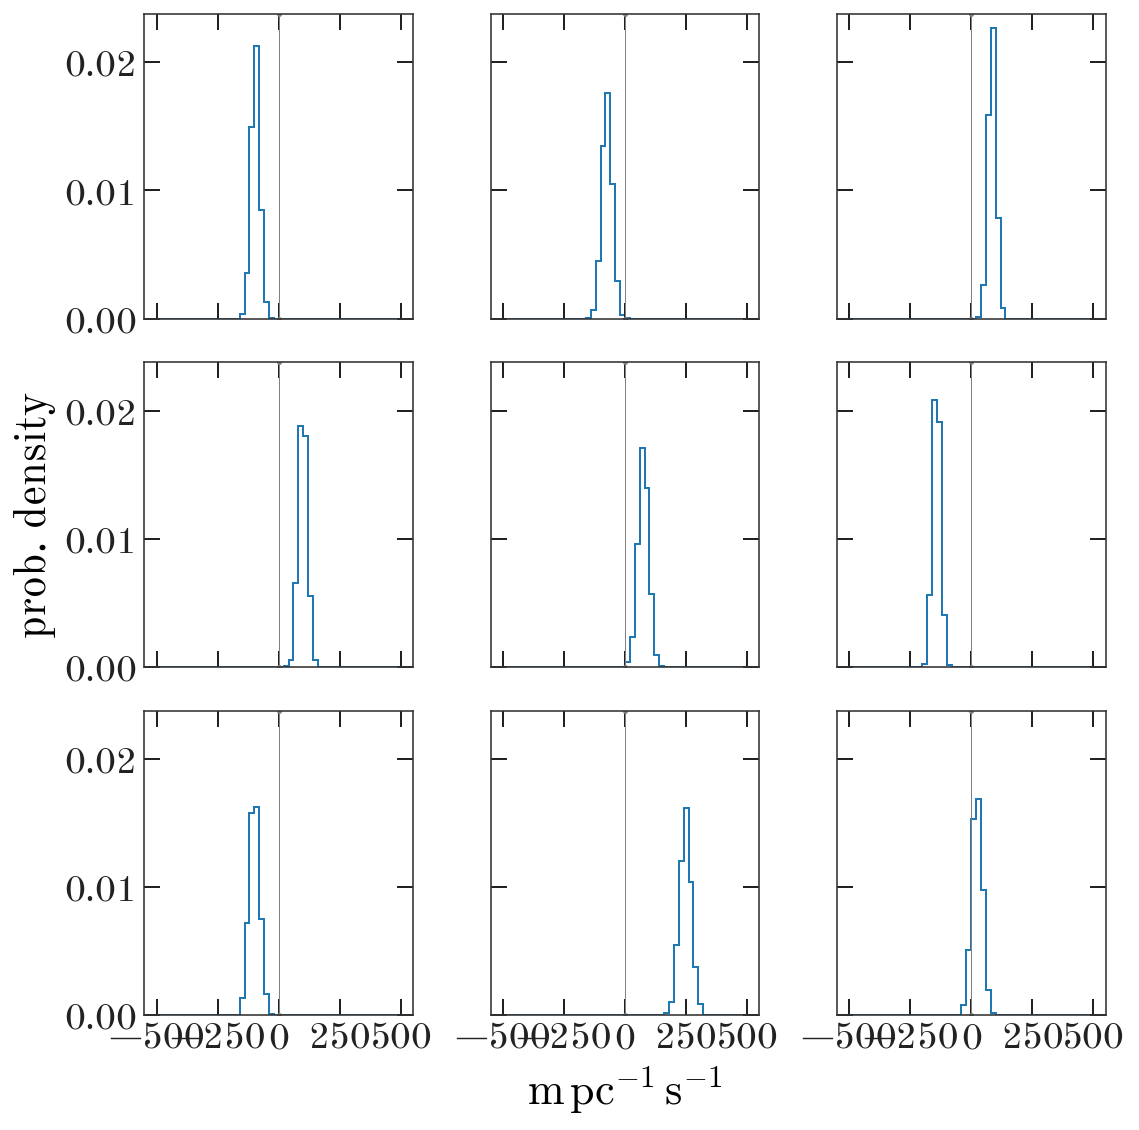

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()
bins = np.arange(-500, 500+1e-3, 20)
for cax, cT in zip(ax, samples["T_param"].reshape((-1, 9)).T):
    cax.hist(cT, bins=bins, density=True, histtype="step")
    cax.axvline(0, c="gray", lw=0.5)
    cax.set_xticks(np.arange(-500, 500+1e-3, 250))
axes[2, 1].set_xlabel("{:latex_inline}".format(u.m/u.s/u.pc))
axes[1, 0].set_ylabel("prob. density")
fig.tight_layout()
fig.set_facecolor('w')
# fig.savefig('../plots/velocity-tensor-{}.png'.format(name), dpi=250)

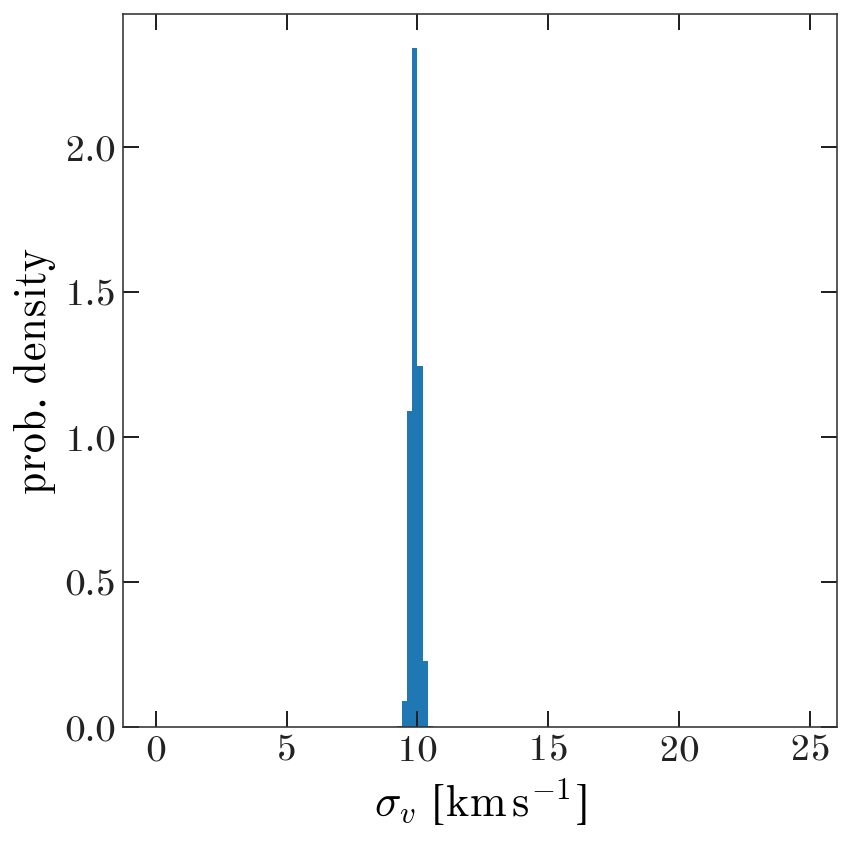

In [28]:
# Velocity dispersion:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(samples['sigv'], bins=np.arange(0, 25, 0.2), density=True);
ax.set_xlabel('$\sigma_v$ [{:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel("prob. density")
fig.tight_layout()
fig.set_facecolor('w')
# fig.savefig('../plots/velocity-dispersion-{}.png'.format(name), dpi=250)

In [41]:
U, S, V = np.linalg.svd(samples["T_param"][0])
S

array([294.76374912, 220.635664  ,  24.37365857])

In [36]:
U @ V

array([[-0.93054191, -0.36595235, -0.01306284],
       [-0.07036238,  0.21369746, -0.97436263],
       [-0.35936179,  0.90576612,  0.22460372]])

In [61]:
np.linalg.qr(U@V)

(array([[-0.93054191,  0.36595235, -0.01306284],
        [-0.07036238, -0.21369746, -0.97436263],
        [-0.35936179, -0.90576612,  0.22460372]]),
 array([[ 1.00000000e+00, -2.77555756e-16,  7.28583860e-17],
        [ 0.00000000e+00, -1.00000000e+00, -1.11022302e-16],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [43]:
from astropy.coordinates import frame_transform_graph

In [45]:
T = frame_transform_graph.get_transform(coord.ICRS, coord.Galactic)

In [52]:
M1 = T.transforms[0].matrix_func(None, coord.FK5)
M2 = T.transforms[1].matrix_func(coord.FK5, None)

In [56]:
(M1 @ M2) @ np.diag(S)

array([[ -16.17532461, -192.71136274,  -11.7928314 ],
       [ 145.64552855,  -98.14529851,   18.20669005],
       [-255.7565379 ,  -43.70271478,   11.11399104]])